# CW2: Natural Language Processing: Classification of News Articles
This coursework extends Lab 8, using the content of news articles to classify them into one of the 4 following categories: `World, Sports, Business, Sci/Tech`.

The original data source is http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html. You do not need to download the data from those websites, it has been made available on GCU learn in the compressed file 'news_dataset.zip', you simply need to download and extract it. You'll get files *train.csv* and *test.csv*. Place them in the same folder as this notebook (or change the path in `pd.read_csv()` accordingly).

Import Conda environmet `lab8_NLP_news.yml`.

In [49]:
!pip install --upgrade --ignore-installed TBB


  Using cached tbb-2021.10.0-py2.py3-none-macosx_10_15_x86_64.macosx_11_0_x86_64.whl (640 kB)


In [50]:
!pip install --upgrade scipy numba daal4py


  Using cached numba-0.58.1-cp39-cp39-macosx_10_9_x86_64.whl (2.6 MB)
  Using cached daal4py-2023.2.1-py39-none-macosx_10_15_x86_64.macosx_11_0_x86_64.whl (2.7 MB)
  Using cached llvmlite-0.41.1-cp39-cp39-macosx_10_9_x86_64.whl (31.0 MB)
  Using cached daal-2023.2.1-py2.py3-none-macosx_10_15_x86_64.macosx_11_0_x86_64.whl (40.9 MB)
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.37.0
    Uninstalling llvmlite-0.37.0:
      Successfully uninstalled llvmlite-0.37.0
  Attempting uninstall: numba
    Found existing installation: numba 0.54.1
    Uninstalling numba-0.54.1:
      Successfully uninstalled numba-0.54.1
  Attempting uninstall: daal4py
    Found existing installation: daal4py 2021.3.0
    Uninstalling daal4py-2021.3.0:
      Successfully uninstalled daal4py-2021.3.0


In [56]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import (
    TextVectorization,
    Embedding,
    LSTM,
    Bidirectional,
    Dense,
    Embedding,
    Conv1D, 
    GlobalMaxPooling1D
)
import tensorflow.keras
from tensorflow.keras.models import Sequential
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier

# 1. Data preparation
Import data. 

In [57]:
# Importing the dataset. As done in lab 4, you usually have a look at the data. Here we simply show the first 5 rows
#train_data = pd.read_csv("train.csv")
#test_data = pd.read_csv("test.csv")
#print(train_data.head(5))
import pandas as pd
try:
    # Load the dataset
    train_data = pd.read_csv("train.csv")
    test_data = pd.read_csv("test.csv")
except FileNotFoundError:
    print("Files not found. Please check the file paths.")
    # Exit if files not found to avoid further errors
    raise
    


In [58]:
# Check class distribution in the training data
class_distribution = train_data['Class Index'].value_counts()
print(class_distribution)

3    30000
4    30000
2    30000
1    30000
Name: Class Index, dtype: int64


# Oversampling: 
Increase the number of samples in the minority classes by duplicating them or using techniques like SMOTE (Synthetic Minority Over-sampling Technique). This can sometimes lead to overfitting but is often preferable to losing data.

In [59]:
from sklearn.utils import resample

# Separate the dataset into different class datasets
df_world = train_data[train_data['Class Index'] == 0]
df_sports = train_data[train_data['Class Index'] == 1]
df_business = train_data[train_data['Class Index'] == 2]
df_scitech = train_data[train_data['Class Index'] == 3]

# Find the number of samples in the largest class
max_size = train_data['Class Index'].value_counts().max()

# Oversample the other classes to match the largest one
df_sports_upsampled = resample(df_sports, replace=True, n_samples=max_size, random_state=123)
df_business_upsampled = resample(df_business, replace=True, n_samples=max_size, random_state=123)
df_scitech_upsampled = resample(df_scitech, replace=True, n_samples=max_size, random_state=123)

# Combine the upsampled datasets with the largest class dataset
train_data_balanced = pd.concat([df_world, df_sports_upsampled, df_business_upsampled, df_scitech_upsampled])

# Shuffle the dataset
train_data_balanced = train_data_balanced.sample(frac=1, random_state=123).reset_index(drop=True)


Change labels from 1-4 to 0-3

In [60]:
# substract 1 from the target variable for both, train and test data
train_data["Class Index"] = train_data["Class Index"] - 1
test_data["Class Index"] = test_data["Class Index"] - 1
label_names = ["World", "Sports", "Business", "Sci/Tech"] # 0 is "World", 1 is "Sports", ...

# Checking the Format and Data Type of Test Labels

Verifying that the labels in our test dataset follow the anticipated format is crucial before moving on with model training and assessment. This step guarantees that the evaluation of our model will be accurate in the future.

The checks listed below are carried out:

# Label Preview: 
Showing the test_data DataFrame's Class Index column's initial few items. We can quickly validate that the label transformation (from 1-4 to 0-3) was effective with this preview.

# Data Type Check: 
Confirming the Class Index column's data type. These labels need to be in an integer format in order for our model and evaluation techniques to function properly.

In [61]:
print(test_data["Class Index"].head())
print("Data type:", test_data["Class Index"].dtype)


0    2
1    3
2    3
3    3
4    3
Name: Class Index, dtype: int64
Data type: int64


## Preprocessing 

Lowercase descriptions and clean up non-letter characters.

**TODO 1**: Remove the occurences of "http" "href", "https" and "www". Also, remove the names of the news agencies (Reuters, AP, ...) from the datasets.

In [63]:
# Function to preprocess the data
import re
    
def preprocess_text(string):
    # Remove URLs
    string = re.sub(r'https?://\S+|www\.\S+', '', string)
    
    # Remove HTML tags
    string = re.sub(r'<.*?>', '', string)
    
    # Remove special characters
    string = re.sub(r'[^a-zA-Z\s]', '', string, re.I|re.A)
    
    # Lowercasing
    string = string.lower()
    
    # Remove news agencies' names
    agencies = ['Reuters', 'AP', 'BBC']
    for agency in agencies:
        string = string.replace(agency.lower(), '')
    
    return string

# Apply the preprocessing
try:
    train_data['Description'] = train_data['Description'].apply(preprocess_text).apply(stem_text)
    test_data['Description'] = test_data['Description'].apply(preprocess_text).apply(stem_text)
except NameError as e:
    print(f"An error occurred: {e}")

Convert dataframes to lists (needed for further functions).

In [64]:
train_data_list = train_data["Description"].tolist()
test_data_list = test_data["Description"].tolist()
train_labels_list = train_data["Class Index"].tolist()
test_labels_list = test_data["Class Index"].tolist()

Create validation set (taking out 20% of test set)

In [65]:
(train_data_list, validation_data_list,
 train_labels_list, validation_labels_list) = train_test_split(train_data_list, train_labels_list, test_size=0.2, stratify=train_labels_list)

### Removing Stop Words
Remove stopwords from the *stopword* corpus.

In [66]:
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

def stem_text(text):
    stemmer = PorterStemmer()
    words = word_tokenize(text)
    return ' '.join([stemmer.stem(word) for word in words])

In [67]:
train_data_list = remove_stopwords(train_data_list)
validation_data_list = remove_stopwords(validation_data_list)
test_data_list = remove_stopwords(test_data_list)

### TODO 2: STEMMING
Use **Stemming** or **Lemmatization** to grammatical word variations.

In [68]:
# TODO 2: YOUR CODE HERE
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def stem_text(text):
    return " ".join([stemmer.stem(word) for word in text.split() if word not in stop_words])

train_data["Description"] = train_data["Description"].apply(stem_text)
test_data["Description"] = test_data["Description"].apply(stem_text)


[nltk_data] Downloading package stopwords to /Users/mac/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 2. Recurrent Neural Network classifier with Keras and Tensorflow

One-hot encode the labels (0 -> 0001, 1 -> 0010, ...) to match NN classifier head output.

In [69]:
# the labels are of value 0, 1, 2, 3. We need to convert them to one-hot encoded vectors

import tensorflow as tf
import numpy as np

# Assuming train_labels_list, validation_labels_list, and test_labels_list are already defined
train_labels = tf.keras.utils.to_categorical(np.array(train_labels_list), num_classes=4)
validation_labels = tf.keras.utils.to_categorical(np.array(validation_labels_list), num_classes=4)
test_labels = tf.keras.utils.to_categorical(np.array(test_labels_list), num_classes=4)

print(train_labels.shape)

#train_labels = tensorflow.keras.utils.to_categorical(np.array(train_labels_list), num_classes=4)
#validation_labels = tensorflow.keras.utils.to_categorical(np.array(validation_labels_list), num_classes=4)
#test_labels = tensorflow.keras.utils.to_categorical(np.array(test_labels_list), num_classes=4)
#print(train_labels.shape)

(96000, 4)


First we use the TextVectorization layer to convert the text to a sequence of integers. You can read about how this works  [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization).


In [70]:
# this will create a vocabulary of the top 2500 words and then convert the text to a sequence of numbers
vocab_size = 2500 # how many of the most frequent words to keep
sequence_length = 30 # how many words we use to represent a description
vectorizer = TextVectorization(max_tokens=vocab_size, output_sequence_length=sequence_length)
# fit the vectorizer on the training data (find the most common words and assign values to them)
vectorizer.adapt(train_data_list)
# show the selected words
print(vectorizer.get_vocabulary())

['', '[UNK]', 'said', 'new', 'us', 'year', 'compani', 'two', 'first', 'wednesday', 'monday', 'world', 'tuesday', 'thursday', 'inc', 'one', 'friday', 'report', 'week', 'game', 'state', 'yesterday', 'last', 'york', 'say', 'presid', 'quot', 'unit', 'million', 'nation', 'corp', 'price', 'time', 'plan', 'day', 'sunday', 'govern', 'offici', 'oil', 'secur', 'group', 'would', 'announc', 'peopl', 'today', 'servic', 'three', 'team', 'month', 'could', 'market', 'iraq', 'win', 'kill', 'percent', 'open', 'saturday', 'night', 'softwar', 'next', 'use', 'end', 'minist', 'season', 'second', 'busi', 'microsoft', 'countri', 'comput', 'make', 'intern', 'lead', 'back', 'expect', 'share', 'network', 'help', 'internet', 'take', 'technolog', 'system', 'record', 'stock', 'washington', 'billion', 'sale', 'may', 'american', 'research', 'citi', 'leader', 'former', 'releas', 'final', 'victori', 'feder', 'home', 'offer', 'top', 'manag', 'attack', 'run', 'bank', 'start', 'forc', 'giant', 'elect', 'player', 'call', '

In [71]:
# vectorize the training data (replace words by their associated values)
train_data_vectorized = vectorizer(train_data_list)
# vectorize the validation data
validation_data_vectorized = vectorizer(validation_data_list)
# vectorize the test data
test_data_vectorized = vectorizer(test_data_list)
# this shape shows that we have our 96000 training examples, each as a vector of 30 integers
print(train_data_vectorized.shape)

(96000, 30)


In [72]:
# see how a vectorized news description looks like
print(train_data_vectorized[1])

tf.Tensor(
[1323  138    1   27   20 1945  225 1278  789  440   67    1    1 1278
    1 2272  225  138  234   78    1 1868  748  866  414  225 1017    1
  487 2140], shape=(30,), dtype=int64)


We then build a RNN.

We use an *Embedding layer* to convert the integer sequences to embeddings. You can read about how this works [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding).

The Bidirectional layer takes the input and passes it forwards and backwards through the LSTM (Long-Short Term Memory) layer. It allows the network to learn the context of the sentence in both directions, so information from both previous and following words is taken into account.


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 32)          80000     
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dense_4 (Dense)             (None, 4)                 260       
                                                                 
Total params: 96900 (378.52 KB)
Trainable params: 96900 (378.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
750/750 [==============================] - 32s 39ms/step - loss: 0.4870 - accuracy: 0.8283 - val_loss: 0.3340 - val_accuracy: 0.8843
Epoch 2/5
750/750 [==============================] - 29s 39ms/step - lo

<AxesSubplot:>

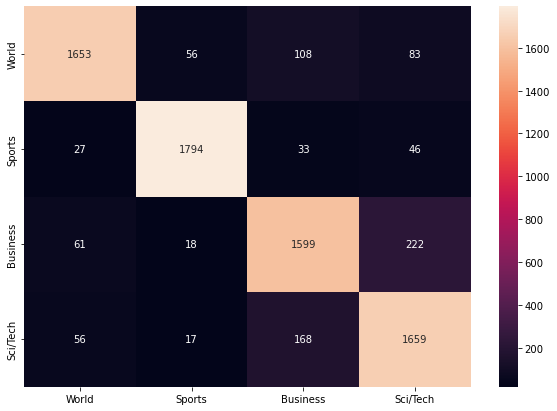

In [73]:
model = Sequential()
model.add(Embedding(vocab_size, 32))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(4, activation="softmax"))

model.summary()

# compile the model
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# fit the model
# Train the model
history = model.fit(
    train_data_vectorized,
    train_labels,
    epochs=5,
    batch_size=128,
    verbose=1,
    validation_data=(validation_data_vectorized, validation_labels),
)


# predict the labels on the test data
rnn_predictions = model.predict(test_data_vectorized)
# since predictions are one-hot encoded, we convert them to an int label taking the output with higher value
rnn_predictions = np.argmax(rnn_predictions, axis=1)

# calculate the accuracy score
accuracy = accuracy_score(test_labels_list, rnn_predictions)
print("Test Set Accuracy: ", accuracy)
# create a confusion matrix
cm = confusion_matrix(test_labels_list, rnn_predictions)
# plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=label_names, yticklabels=label_names)

# TODO 3: Creating Example Predictions
Test the model. Create some fresh sample news (copy them from a news site like BBC) then see if the model can predict the correct labels. Use one example per class.

Also, find one example that gets misclassified and briefly discuss here why it might happen:

In [77]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer

# Tokenization and padding
vocab_size = 2500  
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(train_data["Description"])


# Define the news 
sample_news = [
    "Ukraine war: Ukraine military seeks extra 500,000 soldiers - President Zelensky: Ukraine's military wants to mobilise up to 500,000 extra people, President Volodymyr Zelensky has revealed, as the war with Russia nears a two-year mark. At a news conference in Kyiv, he said his commanders were seeking '450,000-500,000 individuals', admitting this was a 'sensitive' and costly issue. He said he needed more details before backing the move, hinting that 500,000 soldiers were already on the front.",
    "Liverpool 5-1 West Ham: Jurgen Klopp critical of atmosphere before Arsenal visit: Liverpool boss Jurgen Klopp has told any supporter 'not in the right shape' for Saturday's top-of-the-table Premier League encounter with leaders Arsenal to give their ticket to someone else. Klopp - whose side are a point behind the Gunners - criticised the Anfield atmosphere during Wednesday's 5-1 Carabao Cup quarter-final win over West Ham. The Reds galloped to their joint-biggest win of the season to book a two-legged last-four encounter with Fulham.",
    "Google settles $5bn lawsuit for 'private mode' tracking: Google has agreed to settle a US lawsuit claiming it invaded the privacy of users by tracking them even when they were browsing in 'private mode'. The class action sought at least $5bn (£3.9bn) from the world's go-to search engine and parent company Alphabet. Large technology firms have faced increased scrutiny of their practices in the US and beyond. Lawyers representing Google and its users did not immediately respond to the BBC's requests for comment.",
    "Nasa beams cat video from deep space with laser: Nasa has streamed an ultra high-definition video of a cat back to Earth from the depths of space. The 15-second clip of Taters the cat was sent via laser - and fittingly shows it chasing a laser beam. Footage of the orange tabby travelled 19 million miles - some 80 times the distance from Earth to the Moon.",
    "First protests in Argentina against Milei's austerity plan: Thousands of people have taken to the streets of Buenos Aires in the first big protest against the new Argentine government's economic shock policies. President Javier Milei announced measures that include spending cuts and a drastic currency devaluation. He also signed an economic reform decree that will end limits on exports. The march was led by groups that represent the unemployed. Police were deployed in large numbers to stop the protesters from blocking roads."
]

# Preprocess the sample news
sample_news = [preprocess_text(i) for i in sample_news]
sample_news = remove_stopwords(sample_news)

# Stem the sample news (if stemming was part of your preprocessing)
sample_news = [stem_text(i) for i in sample_news]

# Vectorize the sample news
sample_news_vectorized = vectorizer(tf.convert_to_tensor(sample_news))

# Predict using the model
sample_predictions = model.predict(sample_news_vectorized)
sample_predictions = np.argmax(sample_predictions, axis=1)

# Print predictions with labels
for headline, category in zip(sample_news, sample_predictions):
    print(f"Headline: {headline}\nPredicted Category: {label_names[category]}\n")


# Tokenize and pad the headlines
#tokenized_headlines = tokenizer.texts_to_sequences(preprocessed_headlines)
#padded_headlines = tf.keras.preprocessing.sequence.pad_sequences(tokenized_headlines, maxlen=200)


# Analyze the potentially misclassified headline about Argentine protests
argentina_protest_headline = sample_news[-1]
argentina_protest_prediction = label_names[sample_predictions[-1]]

print(f"Selected Headline for Analysis: {argentina_protest_headline}")
print(f"Predicted Category: {argentina_protest_prediction}")
print("Reason for Potential Misclassification: [Your analysis here based on the headline content and the predicted category]")

1/1 [==============================] - 0s 223ms/step
Headline: ukrain war ukrain militari seek extra soldier presid zelenski ukrain militari want mobilis extra peopl presid volodymyr zelenski reveal war russia near twoyear mark news confer kyiv said command seek individu admit sensit costli issu said need detail back move hint soldier alreadi front
Predicted Category: World

Headline: liverpool west ham jurgen klopp critic atmospher arsen visit liverpool boss jurgen klopp told support right saturday topofthet premier leagu encount leader arsen give ticket someon els klopp whose side point behind gunner criticis anfield atmospher wednesday carabao cup quarterfin win west ham red gallop jointbiggest win season book twoleg lastfour encount fulham
Predicted Category: Sports

Headline: googl settl bn lawsuit privat mode track googl agre settl us lawsuit claim invad privaci user track even brows privat mode class action sought least bn bn world goto search engin parent compani alphabet larg 

## TODO 4: Create a new model
Try to improve the RNN model, of implement a CNN (with 1D convolution layers), that beats the baseline RNN

In [75]:
# TODO 4: YOUR CODE HERE
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


# Tokenization and padding
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(train_data["Description"])


# Prepare the sequences
train_sequences = tokenizer.texts_to_sequences(train_data["Description"])
train_padded = pad_sequences(train_sequences, maxlen=200)

test_sequences = tokenizer.texts_to_sequences(test_data["Description"])
test_padded = pad_sequences(test_sequences, maxlen=200)

# Clearing previous model from the session
tf.keras.backend.clear_session()

# Original CNN model architecture
cnn_model = Sequential([
    Embedding(5000, 16, input_length=200),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(10, activation='relu'),
    Dense(4, activation='softmax')
])

# Compile the original CNN model
cnn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 16)           80000     
                                                                 
 conv1d (Conv1D)             (None, 196, 128)          10368     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
 dense_1 (Dense)             (None, 4)                 44        
                                                                 
Total params: 91702 (358.21 KB)
Trainable params: 91702 (358.21 KB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [76]:
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D

# CNN model
cnn_model = Sequential([
    Embedding(5000, 16, input_length=200),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(10, activation='relu'),
    Dense(4, activation='softmax')
])

cnn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_model.summary()

# Train CNN model
cnn_history = cnn_model.fit(train_padded, train_data["Class Index"], epochs=10, validation_split=0.1)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 16)           80000     
                                                                 
 conv1d_1 (Conv1D)           (None, 196, 128)          10368     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
 dense_3 (Dense)             (None, 4)                 44        
                                                                 
Total params: 91702 (358.21 KB)
Trainable params: 91702 (358.21 KB)
Non-trainable params: 0 (0.00 Byte)
________________

--- 

This cell goes to the very bottom of your submitted notebok.
You are requried to link the sources and web-links that you have used for various parts of this coursework. 

Write them sources used in the following format similar to the first examle in the sources list below :

    - what you have used them for : web-link

Sources:

- Implement a recurrent neural network : https://peterroelants.github.io/posts/rnn-implementation-part01/